In [1]:
import pandas as pd
import numpy as np
import umap
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
pd.set_option('display.max_colwidth',None)

2024-09-23 05:05:54.702379: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-09-23 05:05:54.702395: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Data

In [2]:
vec=np.load('data/embeddings/embs_e5.ar.npy',  allow_pickle=True)

In [3]:
vec.shape

(413761, 768)

In [4]:
texts=pd.read_csv('data/embeddings/embs_text_e5.csv')
texts.shape

(413761, 1)

In [5]:
texts_emb=dict()
for i, t in enumerate(texts.text_splitted.tolist()):
    texts_emb[t]=vec[i]

In [6]:
len(texts_emb)

413761

In [7]:
df_orig=pd.read_csv('data/raw/stenos_cleaned_faction2022_topics.csv')
df_orig.shape

(465494, 27)

In [8]:
df_orig.Name_red_outliers

0         273_kohaloleku_kontroll_arupärimisi_töönädala
1         1243_ettekanne_teostamisel_minutit_tegevusest
2          207_ettekanne_sõnavõttudega_minutit_vastused
3               139_ammendumiseni_pikendada_kauem_kella
4                 1461_maksude_maksud_maksudega_mängita
                              ...                      
465489                91_jõuluvana_aplaus_naer_luuletus
465490                91_jõuluvana_aplaus_naer_luuletus
465491                91_jõuluvana_aplaus_naer_luuletus
465492                                   -1_ma_te_me_et
465493                91_jõuluvana_aplaus_naer_luuletus
Name: Name_red_outliers, Length: 465494, dtype: object

In [9]:
df_orig[~df_orig.fation.isnull()].shape

(232059, 27)

In [10]:
df_orig.fation.value_counts()

Eesti Reformierakonna fraktsioon                    50485
Eesti Keskerakonna fraktsioon                       48313
Eesti Konservatiivse Rahvaerakonna fraktsioon       37919
Sotsiaaldemokraatliku Erakonna fraktsioon           31078
Isamaa fraktsioon                                   23842
Isamaa ja Res Publica Liidu fraktsioon              12894
Eesti Vabaerakonna fraktsioon                       11268
Fraktsiooni mittekuuluvad saadikud                   7935
Fraktsioonidesse mittekuulunud Riigikogu liikmed     5618
Erakonna Eestimaa Rohelised fraktsioon               1362
Eestimaa Rahvaliidu fraktsioon                       1050
Eesti 200 fraktsioon                                  295
Name: fation, dtype: int64

## Keep some faction texts

In [11]:
factions2keep=['Eesti Reformierakonna fraktsioon','Eesti Keskerakonna fraktsioon',
               'Eesti Konservatiivse Rahvaerakonna fraktsioon','Sotsiaaldemokraatliku Erakonna fraktsioon',
               'Isamaa fraktsioon', 'Isamaa ja Res Publica Liidu fraktsioon', 'Eesti Vabaerakonna fraktsioon',
              'Erakonna Eestimaa Rohelised fraktsioon', 'Eestimaa Rahvaliidu fraktsioon',
              'Eesti 200 fraktsioon', 'Fraktsiooni mittekuuluvad saadikud',
              'Fraktsioonidesse mittekuulunud Riigikogu liikmed']

df_orig_faction=df_orig[df_orig.fation.isin(factions2keep)]
df_orig_faction.shape

(232059, 27)

## Calculate attention

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Example class for attention-based aggregation of text embeddings
class AttentionAggregator(nn.Module):
    def __init__(self, embedding_dim):
        super(AttentionAggregator, self).__init__()
        # Define a linear layer for computing attention scores
        self.attention_layer = nn.Linear(embedding_dim, 1)
        
    def forward(self, embeddings):
        """
        embeddings: Tensor of shape (n_texts, embedding_dim)
        This represents the text embeddings for a single speaker.
        """
        # Compute attention scores
        attention_scores = self.attention_layer(embeddings)  # Shape: (n_texts, 1)
        attention_scores = attention_scores.squeeze(1)  # Shape: (n_texts)
        
        # Apply softmax to get normalized attention weights
        attention_weights = F.softmax(attention_scores, dim=0)  # Shape: (n_texts)
        
        # Compute the weighted sum of the embeddings
        weighted_embeddings = embeddings * attention_weights.unsqueeze(1)  # Shape: (n_texts, embedding_dim)
        speaker_embedding = torch.sum(weighted_embeddings, dim=0)  # Shape: (embedding_dim)
        
        return speaker_embedding, attention_weights

In [13]:
faction_emb=dict()
faction_weights=dict()
faction_texts=dict()
faction_texts_ar=dict()
embedding_dim = vec.shape[-1]
faction_topics=dict()

for faction  in factions2keep:
    print(faction)
    df_fac_=df_orig_faction[df_orig_faction.fation==faction]
    texts_=df_fac_.text_splitted.tolist()
    faction_topics[faction]=df_fac_.Name_red_outliers.tolist()
    faction_texts[faction]=texts_.copy()
    faction_texts_ar[faction]=df_fac_.text_splitted.copy()
    print(f'no of texts {len(texts_)}')
    # texts_ids_ = texts[texts['text_splitted'].isin(texts_)].index
    # text_embeddings=torch.tensor(vec[texts_ids_])
    text_embeddings=torch.tensor(np.array([texts_emb[t] for t in texts_]))

    # Create the attention aggregator model
    aggregator = AttentionAggregator(embedding_dim)

    # Aggregate the embeddings using the attention mechanism
    faction_embedding, attention_weights = aggregator(text_embeddings)
    faction_emb[faction]=faction_embedding
    faction_weights[faction]=attention_weights

Eesti Reformierakonna fraktsioon
no of texts 50485
Eesti Keskerakonna fraktsioon
no of texts 48313
Eesti Konservatiivse Rahvaerakonna fraktsioon
no of texts 37919
Sotsiaaldemokraatliku Erakonna fraktsioon
no of texts 31078
Isamaa fraktsioon
no of texts 23842
Isamaa ja Res Publica Liidu fraktsioon
no of texts 12894
Eesti Vabaerakonna fraktsioon
no of texts 11268
Erakonna Eestimaa Rohelised fraktsioon
no of texts 1362
Eestimaa Rahvaliidu fraktsioon
no of texts 1050
Eesti 200 fraktsioon
no of texts 295
Fraktsiooni mittekuuluvad saadikud
no of texts 7935
Fraktsioonidesse mittekuulunud Riigikogu liikmed
no of texts 5618


## plot vectors

In [14]:
faction_emb_ar=np.vstack([faction_emb[faction].detach().numpy() for faction in factions2keep])
# Reduce dimensions using UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
reduced_embeddings = umap_reducer.fit_transform(faction_emb_ar)

/home/risto/.local/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/risto/.local/lib/python3.9/site-packages/umap/umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


In [15]:
faction_emb_ar.shape

(12, 768)

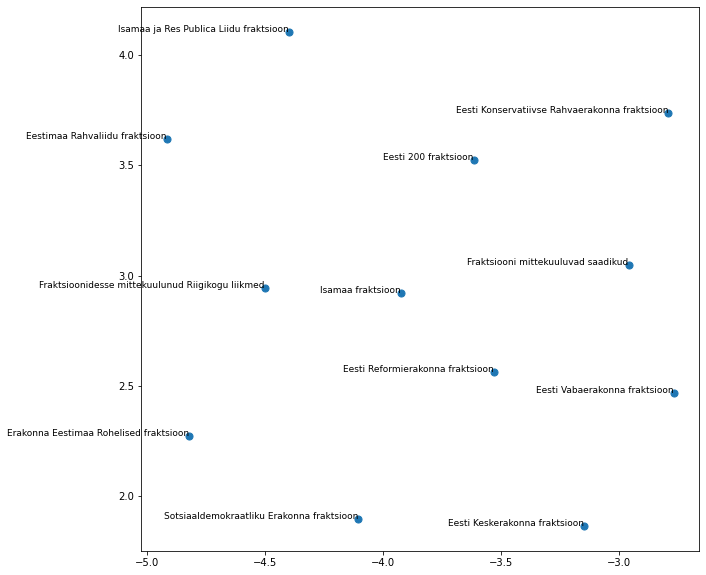

In [16]:
# Plot UMAP-reduced data with clusters
fig, ax=plt.subplots(figsize=(10,10))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=50)
# Adding labels to each point
for i, label in enumerate(factions2keep):
    plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], label, fontsize=9, ha='right')

plt.show()
plt.show()

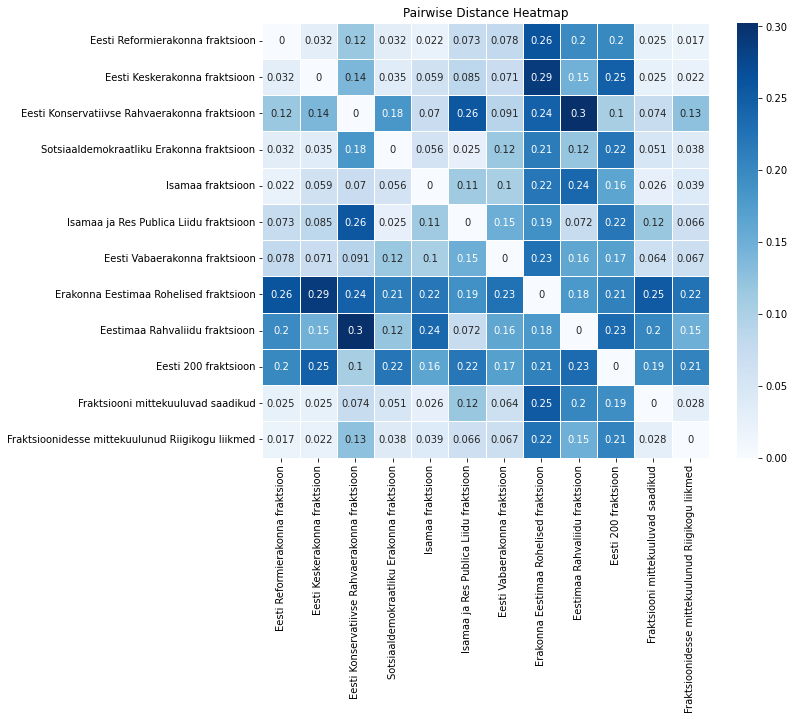

In [17]:
def calc_pairwise_dist(emb_ar, factions2keep):
    distance_matrix = pd.DataFrame(squareform(pdist(emb_ar, metric='cosine')))
    distance_matrix.columns=factions2keep
    distance_matrix.index=factions2keep
    return distance_matrix

def plot_pairwise_distances(emb_ar, factions2keep):
    distance_matrix=calc_pairwise_dist(emb_ar, factions2keep)

    # Step 3: Plot the Distance Matrix as a Heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(distance_matrix, annot=True, cmap='Blues', linewidths=0.5)
    plt.title('Pairwise Distance Heatmap')
    plt.show()

# # Step 2: Calculate Pairwise Euclidean Distances
distance_matrix = pd.DataFrame(squareform(pdist(faction_emb_ar, metric='cosine')))
distance_matrix.columns=factions2keep
distance_matrix.index=factions2keep

# # Step 3: Plot the Distance Matrix as a Heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(distance_matrix, annot=True, cmap='Blues', linewidths=0.5)
# plt.title('Pairwise Distance Heatmap')
# plt.show()

plot_pairwise_distances(distance_matrix, factions2keep)

### try to calculate correlation of x- and y-axis and the word frequency

In [18]:
def find_word_score_corr(faction_texts, factions2keep, scores):
    vectorizer = CountVectorizer(stop_words=None)
    X = vectorizer.fit_transform([faction_texts[faction].values[0] for faction in  factions2keep])  # Word count matrix
    words = vectorizer.get_feature_names_out()  # Get the list of words

    # Step 2: Convert X to a DataFrame for easier analysis
    word_counts = pd.DataFrame(X.toarray(), columns=words)

    # Step 3: Calculate Correlation between Word Frequency and Score
    correlations = {}
    for word in words:
        word_frequency = word_counts[word]
        correlation, _ = spearmanr(word_frequency, scores)  # Spearman correlation between word freq and score
        correlations[word] = correlation

    # Step 4: Create a DataFrame with words and their correlation with score
    correlation_df = pd.DataFrame(list(correlations.items()), columns=['word', 'correlation'])

    # Step 5: Sort by correlation to find the words most correlated with high and low scores
    correlation_df = correlation_df.sort_values(by='correlation', ascending=False)
    return correlation_df

In [20]:
find_word_score_corr(faction_texts_ar, factions2keep, reduced_embeddings[:, 0]).head(30)

,word,correlation
544,võimalik,0.521430
270,neid,0.518200
266,nagu,0.518200
369,riikliku,0.518200
186,lihtsalt,0.518200
224,maksustamise,0.518200
203,ma,0.511006
572,ütlevad,0.480384
243,milliste,0.480384
25,arupärimisele,0.480384


In [21]:
find_word_score_corr(faction_texts_ar, factions2keep, reduced_embeddings[:, 1]).head(30)

,word,correlation
520,vastu,0.591312
319,pensioniiga,0.569810
135,kes,0.554700
295,oma,0.518200
483,tunduvalt,0.480384
462,tema,0.480384
33,asetaks,0.480384
166,käivad,0.480384
165,kus,0.480384
353,rahvaesindajad,0.480384


### find x and y score and topic relationship

In [22]:
# faction_topics_l=[faction_topics[faction] for faction in  factions2keep]
# faction_topics_l_flat=[item for sublist in faction_topics_l for item in sublist]

df_scores=pd.DataFrame()
for i, faction in enumerate(factions2keep):
    faction_topics_l_=faction_topics[faction]
    faction_scores=reduced_embeddings[i, 0]
    df_score_=pd.DataFrame({'topic':faction_topics_l_, 'score':[faction_scores for _ in range(len(faction_topics_l_))]})
    df_scores=pd.concat([df_scores, df_score_], axis=0)

In [23]:
df_scores.groupby('topic').score.mean().sort_values(ascending=False)

topic
1050_kbfi_ülikooliga_keemilise_füüsika                     -2.769647
720_ettekanne_õiguskantsleri_madise_suulise                -2.769647
1325_pikendamine_täitmisel_rahvusvaheliste_kohustuste      -2.769647
1333_maripuu_maret_sotsiaalkomisjoni_liikme                -2.769647
443_käsitlemise_lõpetan_tänu_küsimuse                      -2.781668
                                                              ...   
346_määranud_seisukohtade_edastanud_arvamuse               -4.501652
1581_sotsiaalharta_tõrjutuse_ratifitseerimata_täiendatud   -4.660632
350_sätestatule_osalevad_adressaadile_kolmapäeval          -4.661521
1792_rohelised_eestimaa_roheliste_muudatusettepanekut      -4.722147
896_korb_valeri_nr_hääletustulemused                       -4.821391
Name: score, Length: 1635, dtype: float32

In [24]:
df_scores=pd.DataFrame()
for i, faction in enumerate(factions2keep):
    faction_topics_l_=faction_topics[faction]
    faction_scores=reduced_embeddings[i, 1]
    df_score_=pd.DataFrame({'topic':faction_topics_l_, 'score':[faction_scores for _ in range(len(faction_topics_l_))]})
    df_scores=pd.concat([df_scores, df_score_], axis=0)
    
df_scores.groupby('topic').score.mean().sort_values(ascending=False)

topic
729_nuti_nutt_mart_põhiseaduskomisjoni                    4.106091
1553_küsija_aeg_küsitavused_likvideeritud                 4.106091
885_seppik_jätnud_vaheaeg_ain                             4.106091
222_heili_esmaspäevast_tõnissoni_istungjärgu              4.106091
510_pevkuri_hanno_sotsiaalminister_arupärimisele          4.106091
                                                            ...   
1957_simson_kadri_protseduuriline_velman                  1.862234
1107_vaher_ken_marti_ametikaaslaselt                      1.862234
1606_palub_muudatusettepanekut_fraktsioon_keskerakonna    1.862234
471_soosaar_mark_küsimuseks_tuus                          1.862234
2014_kitarri_laulab_mängib_kop                            1.862234
Name: score, Length: 1635, dtype: float32

### see most important texts for each faction

In [25]:
def show_mostimportant_faction_texts(faction, faction_texts, faction_weights, n=10):
    indices=faction_weights[faction].sort(descending=True).indices
    return faction_texts[faction].reset_index().iloc[indices.numpy()].head(n)

In [27]:
show_mostimportant_faction_texts('Eesti Reformierakonna fraktsioon', faction_texts_ar, faction_weights)

,index,text_splitted
36469,314066,kultuuri- ja haridusuuringutele et tagada eesti hariduse keele- ja kultuuriruumi kestvus eesti keelest erineva emakeelega õpilaste toetamiseks eesti keele omandamisel on kavandatud kokku 8 miljonit eurot sellest 3 miljonit on ette nähtud koolieelsetele lasteasutustele. eesti keele ja eestluse tulemusvaldkonna eesmärgi saavutamiseks on loodud keeleprogramm eelarvest eraldatakse 58 530 eurot meede eesti keele kui teise keele õpetamise tagamine ja õppe toetamine meetme eesmärk on parandada ja laiendada eesti muukeelse elanikkonna eesti keele oskust 863 000 eurot ja lõimumisprogramm 13 740 eurot
18320,160940,selleks et muuta rahastamise regulatsioone selgemaks ja konkreetsemaks ning järelevalvemeetmed ja asjakohased sanktsioonid tõhusamaks konkreetsemalt öeldes täpsustatakse eelnõus annetamise reegleid konkretiseeritakse keelatud annetuste sisu ning nendele reageerimise ja nende eest karistamise korda sätestatakse piirangud laenutegevusele et vältida lõhkilaenamist ning täpsustatakse erakonna majandustegevuse reegleid
46271,417754,suur tänu küsimuse eest arutelud siin saalis niimoodi liiguvad veidi ootamatutes suundades palju küsimusi minu eelkõnelejale oli tulumaksu osas kuigi me arutame nagu käibemaksuküsimust aga mis siin kõlasid väited et see tulumaksu langetamine see kuidagi raskendab inimeste olukorda ma tahan seda natukene selgitada et see maksuküürust loobumine ehk siis maksuvaba tulu alanemine palgavahemikus 1200 2200 eurot et selle võrra 1% skp-st langevad tööandja kulutused töötajatele kui võrrelda kokku palgakulusid ja kättesaadavat netopalka see on 1% skp‑st see on umbes 400
41398,360537,parema elustandardi tõttu nautida mis oleksid need võtmesõnad et euroopa oleks ka edaspidi kõige arenenuma majandusega maailmajagu
2397,22505,austatud riigikogu meenutuseks selle eelnõu eesmärk on anda riigikogu otsusega nõusolek euroopa investeerimispangas ühendkuningriigi märgitud kapitali asendamiseks teiste liikmesriikide sh eesti poolt tuletan meelde ka seda et rahalist sissemakset me ei tee meie osa kasv kaetakse panga reservide arvel esimene lugemine toimus 21. novembril ja muudatusettepanekuid tähtajaks ei laekunud arutasime teist lugemist ette valmistades seda eelnõu rahanduskomisjonis 3. detsembril ja käisime olulisemad teemad veel üle aga mingeid muudatusi ega midagi sarnast ei tehtud nii et saab öelda et tegime täielikus
43372,374818,asub ja mis positsioonil asute teie kas meil on oodata suuremaid laene nagu te lubate rohkemat rahakulutust ppp abil näiteks erasektorilt laenamist või on oodata maksulangetust ja kulutuste kokkutõmbamist mis see filosoofiline lähenemine nüüd ikka on kas vasakule või paremale kuhu me täpselt läheme
15940,138560,lugupeetud juhataja lugupeetud riigikogu liikmed muudatusettepanekuid sellele eelnõule tähtajaks 4. maiks ei laekunud eelnõu menetlus esimese ja teise lugemise vahel toimus kahel komisjoni istungil nimelt 16. ja 29. mail ma meenutan lühidalt mida selle seadusega soovitakse reguleerida nimelt on olemas euroopa pangakontode arestimismäärus ja nüüd me loome regulatsiooni selle määruse riigisiseseks rakendamiseks kaks asja muutuvad siis hõlpsamaks võlgade piiriülene sissenõudmine tsiviil- ja kaubandusasjades ning võlgniku euroopa liidus asuvate pangakontode arestimine 16. mail tutvustas komisjonile oma seisukohti asjasse puutuv osapool kohtutäiturite
29955,257721,17. veebruaril ettepanekuga esimene lugemine lõpetada ning määrata muudatusettepanekute tähtajaks vastavalt meie töö- ja kodukorra seadusele 4. märts kell 18. majanduskomisjon otsustaski konsensusega teha ettepaneku võtta esimene lugemine päevakorda 17. veebruaril ning esimene lugemine lõpetada muudatusettepanekuid ootame majanduskomisjoni 4. märtsiks kella 18-ks aitäh
37526,323727,"palju töötajaid kes vajavad abi kas te arvate et sellest 2,1 miljonist piisab ida-virumaa aitamiseks ja sealse majanduse käigus hoidmiseks ka pärast seda kui need piirangud lõpevad kas need ettevõtjad jäävad ellu"
27262

In [28]:
show_mostimportant_faction_texts('Eesti Keskerakonna fraktsioon', faction_texts_ar, faction_weights)

,index,text_splitted
40018,362781,500 apteeki kõik maa-apteegid ei suuda sellega kaasa minna ja ilmselt peavad uksed sulgema praegu külastab apteeke 70% vanemaid inimesi kes ei tea arvutimaailmast ja digiretseptist suurt midagi kumb on tähtsam kas inimeste ravimine või e-lahenduste juurutamine eesti arstide liit tegi ettepaneku kasutada kuus kuud paralleelselt tavaretsepti seda ei võetud kuulda mina isiklikult toetan digiretsepti kasutuselevõttu aga samas olen seda meelt et peab säilima ka paberretsept nii nagu mujal euroopas see ongi rõõm oli kuulda et minister selle esmakordselt siin
15615,142747,proua juhataja hea minister juba aastal 2008 käivitusid tervise infosüsteemi ehk digiloo esimesed rakendused eesmärk oli muidugi üllas parandada ravi kvaliteeti ja suurendada patsientide rahulolu nüüd on selle rahuloluga nii et aastad on läinud aga tervise infosüsteem ehk tis ei tööta siiamaani nii nagu peaks probleeme on sellega et haiglad kasutavad eri programme ja rakendusi väidetavalt on neli tarkvararakendust mis hästi ei ühitu kui arst kannab patsiendi andmed oma haigla rakendusse siis tervise infosüsteemi satub see alles pärast seda kui
17518,162531,kliimaeesmärgid on jätkuvalt prioriteet võiksime astuda veelgi jõulisema sammu rohelisema planeedi suunas ja suurendada taastuvenergia osakaalu eesti energiatarbimises selleks tuleb muu hulgas soodustada tuule- päikese- või bioenergia kasutuselevõttu hoonete puhul samuti saame lisarahastuse toel viia e-teenused ja riigi it-lahendused uuele tasemele muutes teenused võimalikult nähtamatuks ja proaktiivseks tervishoiuvaldkonnas saame luua tänapäevase e-tervise platvormi kuhu lisanduvad geeniuuringute andmed ja kasutaja soovi korral ka nutiseadmete kogutud andmed e-tervise lahenduste rõhk peab olema haiguste ennetamisel kasutaja saab kutseid uuringutele ning infot potentsiaalsete terviseprobleemide
30837,274424,aitäh austatud juhataja lugupeetud ettekandja id-kaardi kehtivusaeg oli minevikus kümme aastat ja selle turvasertifikaadi kehtivusaeg kolm aastat nüüd on sertifikaadi kehtivusaeg pikendatud viie aastani miks ei võiks id-kaart kui plastkaart kehtida kümme aastat ja iga viie aasta tagant värskendataks lihtsalt sertifikaati
38525,346520,eesti 56 uut esmatasandi tervisekeskust kaasaegsed tervisekeskused aitavad vähendada teenuste killustatust ning tuua kvaliteetse arstiabi inimestele lähemale tervisekeskuste rajamine toob peremeditsiinis kaasa suure muutuse aitab tugevdada perearstide meeskondi pakkuda inimestele laiemat ringi teenuseid ja diagnostikavõimalusi panustades esmatasandisse toome terviseteenused inimestele lähemale saame sekkuda varem et ennetada haiguste süvenemist pakkuda õigeaegset ravi krooniliselt haigetele hoolitseda inimeste eest kogu nende elu vältel praegune covid-19 haigusest tingitud kriis on ilmekalt näidanud kui oluline on et kõigil inimestel oleks võimalikult kodu lähedal juurdepääs vajalikule
391,3675,proua juhataja austatud riigikontrolör lugupeetud kolleegid heal arstil kes on raske haiguse diagnoosinud on alati kaks võimalust ta kas räägib patsiendile ausalt tema haigusest või sosistab sellest kõrva patsiendi sugulastele eesti vabariigi riigikontroll on meie riigi jaoks seesama arst ning ta on valinud ainsa õige tee rääkida julgelt ja avameelselt probleemidest mis meie elu painavad ja seda ka kaugemas perspektiivis riik on haige sümptomid räägivad iseenda eest võib pisteliselt võtta ülevaates kajastatud ühe või teise teema näiteks õigusaktide mõju hinnatakse
3018,24890,läheb riigile maksma kokku hinnanguliselt 380 miljonit eurot ning selle valmides saavad meie tublid meditsiinitöötajad maailmatasemel töötingimused ja patsiendid parima võimaliku ravi tallinna haigla rajamise kõrval pöörame tähelepanu ka maakonnahaiglatele see on vajalik tervishoiu valdkonna võimekuse tõstmiseks seoses kriisidega parema arstiabi osutamiseks ja kaasajastamiseks ehitatakse uus viljandi maakonnahaigla tervisekeskus ja renoveeritakse psühhiaatriakeskus samuti saavad toetust 

In [29]:
show_mostimportant_faction_texts('Sotsiaaldemokraatliku Erakonna fraktsioon', faction_texts_ar, faction_weights)

,index,text_splitted
10685,145363,diskussioonis praegu kaasa rääkida miks komisjon ei toetanud seda et see muudatusettepanek praegu meie ees selle eelnõu muudatusettepanekute tabelis oleks
22256,308697,oli poolt 7 vastu erapooletuid 2. mkm ei toetanud seda muudatusettepanekut ja nad selgitasid komisjonile et hädaolukorra seaduse kehtiv regulatsioon sisustab katastroofi mõiste järgmiselt keskkonna ulatuslik keemiline bioloogiline või radioaktiivne saastamine ulatuslik tulekahju või plahvatus raskete tagajärgedega laeva- lennuki- rongi- või muu transpordivahendiga juhtunud õnnetus või muud põhjused seega on seadusest tulenevalt esitatud kaks konkreetselt defineeritud võimalikku juhtu ja asjaolu millal võib parvlaevaühenduse katkemist käsitleda katastroofina need on laevaõnnetus ja ulatuslik tulekahju või plahvatus peale selle on hädaolukorra seadusest tulenevalt
14142,199455,kas eesti tahab olla suletud või avatud riik see ei ole otsus millega seoses eesti peaks midagi ära andma seda on näidanud ka nüüdseks pikalt käinud protsessid me seisame ühiselt selle eest et eestis oleks turvaline elada ja oleme aastaid töötanud selle nimel et siin oleks keskkond kus tunnevad end ohutult ja hästi kõik inimesed soovime ju näha et meie teadus areneks et meie ärikeskkond õitseks ja et meil oleks võimalik siia kaasata lisandväärtust ka väljastpoolt ning see et me
11932,162538,ja tugev euroopa on kahtlemata eesti majanduse aga ka julgeolekupoliitika huvides mööda ei saa sellestki et sarnaselt euroopa liidu eelarvega saame me taastamispaketist tuge rohkem kui ise sellesse panustame sotsiaaldemokraatidele on ääretult sümpaatne et abipakett on tehtud pikemat perspektiivi arvestades euroopa komisjoni väljapakutud pakett näeb ette et majanduskriisist väljumise toetamine keskenduks ka kliimamuutuste leevendamisele ja innovatsiooni edendamisele need kaks on ka eesti suured eesmärgid õiglane rohepööre ja digipööre tagavad ühtlasi globaalses plaanis euroopa pikaajalise konkurentsivõime parandamise päästekava fookus on loomulikult
13127,180704,jah on oluline mõju lennuohutus muutub paremaks turvalisus on suurem kui te lugesite seletuskirja siis seal on räägitud võib-olla sellisest väga kitsast mõjust konkreetse eelnõu rahanduslikest mõjudest jne tegelikult on lennuohutusel väga suur mõju kogu maailma poliitikale võtame või ukraina kohal alla tulistatud lennuki lennuohutusel on väga suur mõju kogu meie elukorraldusele see küsimus oli esitatud filosoofilises plaanis seda me komisjonis ei arutanud
22670,313884,ja jevgeni on numbriliselt teile ette joonistanud puust ja punaseks teinud olukord on tõsine palun suhtuge sellesse tõsiselt ja tehke midagigi hulk aega on maha magatud teie enda erakonna aseesimees on korduvalt öelnud et ennetamine ongi sellepärast ennetamine et püütakse ära hoida kõige hullemat hakake palun seda tõsiselt võtma tänan
9143,128080,pärast väga kahju samuti ei kaunista teid kuidagi see et te spekuleerite ja võrdlete oma kolleege siin interrindega toetudes henn põlluaasa propagandateosele see on minu arvates äärmiselt inetu ja ma loodan et te leiate põhjuse vabandamiseks
8939,125800,sellises tööskeemis avaldub probleemkomisjoni nõrkus
11203,150628,eestis raiutakse liiga palju metsa tegelikult on sama meelt ka valdav osa ökolooge kes on veendunud et metsade ökoloogilisi väärtusi tuleb senisest tõhusamalt kaitsta ning et metsamajandamise huvide esiplaanile seadmisega eesti riigi poolt viimastel kümnenditel on tehtud tõsist kahju nii liigirikkusele kui ka metsade laiemale mitmekesisusele ja nende ökoloogilisele võimele kahtlemata on olulise lisateemana tõstatunud ja lisandunud sellesse diskussiooni globaalne kliimakriis ja globaalsest kliimakriisist tulenevad otsused mida on langetatud ka euroopa liidu tasandil ja millega eesti on liitunud nimelt kliimaneutraalsuse
964,16559,on tegelikult patsiendi jaoks tervishoiusüsteemi jaoks tervikuna nii palju positiivset siis kas ei peaks andma osapooltele nii ketiapteekidele kui ka proviisoritele selg

In [30]:
show_mostimportant_faction_texts('Eesti Konservatiivse Rahvaerakonna fraktsioon', faction_texts_ar, faction_weights)

,index,text_splitted
20968,381276,ehk siis maakeeli öeldes kellele see kasulik on igatahes mitte eesti riigile ega rahvale aitäh
25116,401286,töötama ehitusobjektide peal aga me ei taha minna ametlikult tööle sellepärast et me kaotame oma hüvised eesti sotsiaalsüsteemis meil ei ole mingit huvi nii et ma arvan et siin peab hakkama tegelema sellega et kutsume üles ettevõtjaid andma teada nendest kes mustalt töötavad need välismaalased kes meil siin on
24360,397915,tõenäosusega kaotab ta peagi saadikupuutumatuse on võtmeisik porto franco aga võib-olla ka laiemalt mõnede muude juurde tulevate teemade kohtulahendite kohtuprotseduuride toimumisel me ei saa hääletada sellise inimese balti assambleesse määramise poolt mul ei ole personaalselt mihhaili vastu mitte midagi ka tema isaga kui valeri korb oli eelmises koosseisus riigikogu liige oli meil minu arvates päris meeldiv omavaheline keemia aga poliitika on poliitika nagu vene sõjaväes öeldakse služba ne družba ehk teenistus ei ole sõprus ja kui teenistus dikteerib teatud pragmaatilisi
8845,185960,ütles või mis te kostate selle asja peale
6884,145752,"reeglid ja ma olen kohustatud esitama teile ettenähtud küsimused nüüd pean ma ütlema teile järgmist, jätkas kawabata kuna ma olen juba maininud et meie firma on tegelikult pigem klann siis on ka meie töötajad pigem klanni liikmed kui kaastöötajad ja kohustused mida nad enda peale võtavad erinevad samuti tavalistest kohustustest mille võtab enda peale palgatööline lihtsamalt öeldes võetakse teid vastu meie klanni liikmeks mis on üks iidsemaid jaapanis vakantne ametikoht millele te asute kannab nimetust mänedžeri abi ärisuhetes põhjapoolsete barbaritega"
25864,403536,suur tänu lugupeetud istungi juhataja mina ütlen ka selgituseks nii palju et me ei küsi lihtsalt kiusamise pärast vaid tegelikult ikkagi täiesti siirast murest kantuna tundub et meil siin reeglid ei kehti või vähemalt me ei saa aru kuidas neid reegleid saab pidevalt muuta ma küsin teie käest ühe väga lihtsa küsimuse hästi selge lihtne küsimus kas istungi juhataja on seotud kõnede registreerimise järjekorraga või ei ole seotud nii et võite järjekorras olijaid rahulikult ümber tõsta kas selline reegel kehtib
4012,97313,meil ministrile mitmeid küsimusi aitäh
3915,93395,moodustatud ettevõtte juht baiba rubesa siis kas üheks bilderbergi grupi kohtumise küsimuseks võiks olla ka rail balticu tuleviku küsimus rahastuse küsimus kas uue poliitilise kultuuri ja valitsemiskultuuri väljendus võiks olla see et te avate natukene seda katteloori
17854,338518,või ootame ära millal see seal taga on väga suured emotsioonid üleval millegipärast
37279,461919,aga oluline on see ja mitte ainult et ta ei ole nende isikute suhtes aa jaa ja siis veel kümme lehekülge tuleb täita ankeeti ja nagu ma lugesin siin on komisjon ikka väikese edu saavutanud nüüd ei tule täita mitte kümme lehekülge vaid kuus lehekülge müts maha majanduskomisjoni ees neli lehekülge selliseid andmeid saite maha nudida sealt seegi hea asi eriti puudutab see just seda ja see ei ole mitte ainult isikute vaid ka tööandjate puhul kes ütlevad et võrreldes


In [31]:
show_mostimportant_faction_texts('Eesti 200 fraktsioon', faction_texts_ar, faction_weights)

,index,text_splitted
139,407603,suur tänu lugupeetud riigikogu esimees austatud välisminister head kolleegid ja külalised välisminister margus tsahkna esitas välisministeeriumi ja kogu valitsuse välispoliitikaotsuseid arvestades väljakujunenud julgeolekuolukorra tõsidust ja selle perspektiive mis kahjuks ei luba positiivseid arenguid idasuunalt erakonna eesti 200 fraktsiooni nimel soovin pöörata tähelepanu mõnele olulisele aspektile esiteks erakondadeülene koosmeel mis peegeldab kogu meie rahva ühtsust on eluliselt tähtis seda eriti kriitilistel aegadel me räägime eesti iseseisva ja demokraatliku riigi püsimajäämisest nii oli see enam kui 30 aastat tagasi kui me taastasime
28,380326,kõik aru informatsiooni ligipääsetavuse probleemiga on inimesed laialdaselt kokku puutunud ka siis kui mõne asja lugemiseks näiteks arvutiekraanil pole tarkvara ühildumist it-sektorile on informatsiooni ligipääsetavuse tagamine olnud seetõttu väga oluline eesmärk ja loodetavasti on edaspidigi aga kõige selle kõrval on veel üks oluline informatsiooni ligipääsetavuse aspekt ja see puudutab otseselt riigikogu tööd euroopa liidu asjade komisjonis näiteks töötame me hoolega läbi üsna keerulisi ja mõnikord ka pakse materjale kõikvõimalikest valdkondadest neid läbi lugedes avastavad ka väga kõrgelt haritud inimesed kes
39,382179,reaalseid täies valmiduses kaitsejõudusid me kulutame ju riigikaitsele 3% riigi sisemajanduse koguproduktist või isegi rohkem kuid sellest on kasu ainult siis kui kaitsevägi saab väljaõppe harjutusväljadel kus ta muidu selle väljaõppe saab selleks et tagada oma kaitsevalmidust ma soovin tänada siin kõiki asjaosalisi riigikaitsekomisjoni liikmeid fraktsioone kaitseministeeriumi keskkonnaministeeriumi ja teisi ministeeriume kuid loomulikult eelkõige arvukaid kodanikke ja mittetulundusühinguid kes esitasid oma arvamusi ja ettepanekuid oleme kõiki asjast huvitatuid kaasanud ning kõigi mõistlike ettepanekutega arvestanud rõhutan et kohtusime kaasatud mtü‑dega riigikaitsekomisjoni
45,385258,austatud riigikogu erakond eesti 200 fraktsiooni nimel esitan ma riigikogu esimehe kandidaadiks lauri hussari lauri on õiglane mees kindla käega juht ja kindlasti oleks hea juht ka riigikogule mistõttu palun tema kandidatuuri toetada aitäh
17,380303,võimalikult kiirest rakendumisest on seniste arutelude põhjal huvitatud kõik riigikogu fraktsioonid
119,405526,tänan lugupeetud riigikogu esimees proua peaminister tänan ettekande eest ja vastuste eest küsimustele ma tahan omalt poolt rõhutada et riigikaitsekomisjon mõistab täielikult laiapindse riigikaitse olemust ja sealhulgas riigikaitse mittesõjaliste aspektide olulisust ja see peegeldub riigikaitsekomisjoni igapäevase töö fookuses meid on briifitud regulaarselt riigikaitse mittesõjalistel teemadel mis puudutavad siseministeeriumi tegevust sealhulgas elanikkonnakaitsega seotud tööd politsei- ja piirivalveameti ja teiste struktuuride tööd samuti on palju räägitud nendest probleemidest ja vajadustest ma pean siinjuures vajalikuks ära märkida et ma toetan laiapindse riigikaitse püsirahastust
212,432739,ja kodanike ettepanekutega on küll ma olen väga tänulik selle eest kogu komisjoni nimel kaasatutele et nad on neid ettepanekuid esitanud nad on osalenud ka meie istungil 25. mail me kuulasime neid arutasime põhjalikult neid ettepanekuid ja nendega on arvestatud enn eesmaa väga hea kolleeg on meie komisjoni liige ma olen täiesti kindel et ta on informeerinud keskerakonna fraktsiooni aruteludest komisjonis ei ole võimalik et enn ei ole seda teile edasi andnud nii et see paneb tõesti imestama miks te
40,382180,istungil 25. mail arutasime pikalt ja põhjalikult kõiki aspekte see on protokollitud ning arvestasime nende ettepanekutega eelkõige 8. muudatusettepaneku raames lõpuks soovin tänada neid kohalikke inimesi ja kohalikke omavalitsusi keda nursipalu harjutusvälja laiendamine otseselt puudutab on olnud emotsioone on olnud teravaid küsimusi ja etteheiteid vaidlusi kuid ma arvan et nüüd me oleme seal kus lõpli

## Autoencoder

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder: maps the input to a latent space (lower-dimensional representation)
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        
        # Decoder: reconstructs the input from the latent space representation
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()  # Use Sigmoid if the input embeddings are normalized between 0 and 1; otherwise, omit this.
        )
        
    def forward(self, x):
        # Forward pass through encoder and decoder
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent

#### Example usage

In [34]:
def train_var(speaker_embeddings, device='cuda', latent_dim=50, n_epochs = 1000):
    embedding_dim = speaker_embeddings[0].shape[-1]
    # Combine all speakers' embeddings into a single tensor
    all_speaker_embeddings = torch.vstack(speaker_embeddings)

    # Keep track of how many texts each speaker has
    num_texts_per_speaker = [embeddings.shape[0] for embeddings in speaker_embeddings]

    device='cuda'
    # Create an instance of the Autoencoder model and move it to the GPU
    autoencoder = Autoencoder(input_dim=embedding_dim, latent_dim=latent_dim).to(device)

    # Define the loss function (Mean Squared Error) and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

    # Training the autoencoder with all speaker embeddings at once
    for epoch in range(n_epochs):
        autoencoder.train()

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass with all embeddings from all speakers
        reconstructed, latent = autoencoder(all_speaker_embeddings.to(device))

        # Compute reconstruction loss
        loss = criterion(reconstructed, all_speaker_embeddings.to(device))

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Print the loss every 100 epochs
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.4f}')

    # After training, the latent space representation (compressed embeddings) is what we're interested in
    with torch.no_grad():
        _, latent_embeddings = autoencoder(all_speaker_embeddings.to(device))

    # Split the latent embeddings back by speaker based on the number of texts per speaker
    start_idx = 0
    speaker_latent_embeddings = []
    for num_texts in num_texts_per_speaker:
        end_idx = start_idx + num_texts
        speaker_latent_embeddings.append(latent_embeddings[start_idx:end_idx])
        start_idx = end_idx
    return speaker_latent_embeddings
    
    

latent_dim = 50  # Dimension of the compressed embedding (latent space)

speaker_embeddings=[]
for faction  in factions2keep:
    print(faction)
    texts_=df_orig_faction[df_orig_faction.fation==faction].text_splitted
    faction_texts[faction]=texts_.copy()
    print(f'no of texts {texts_.shape[0]}')
    texts_ids_ = texts[texts['text_splitted'].isin(texts_)].index
    speaker_embeddings.append(torch.tensor(vec[texts_ids_]))
    
speaker_latent_embeddings=train_var(speaker_embeddings) 

Eesti Reformierakonna fraktsioon
no of texts 50485
Eesti Keskerakonna fraktsioon
no of texts 48313
Eesti Konservatiivse Rahvaerakonna fraktsioon
no of texts 37919
Sotsiaaldemokraatliku Erakonna fraktsioon
no of texts 31078
Isamaa fraktsioon
no of texts 23842
Isamaa ja Res Publica Liidu fraktsioon
no of texts 12894
Eesti Vabaerakonna fraktsioon
no of texts 11268
Erakonna Eestimaa Rohelised fraktsioon
no of texts 1362
Eestimaa Rahvaliidu fraktsioon
no of texts 1050
Eesti 200 fraktsioon
no of texts 295
Fraktsiooni mittekuuluvad saadikud
no of texts 7935
Fraktsioonidesse mittekuulunud Riigikogu liikmed
no of texts 5618
Epoch [100/1000], Loss: 0.0013
Epoch [200/1000], Loss: 0.0013
Epoch [300/1000], Loss: 0.0013
Epoch [400/1000], Loss: 0.0009
Epoch [500/1000], Loss: 0.0008
Epoch [600/1000], Loss: 0.0008
Epoch [700/1000], Loss: 0.0008
Epoch [800/1000], Loss: 0.0008
Epoch [900/1000], Loss: 0.0008
Epoch [1000/1000], Loss: 0.0008


In [35]:
# Print the resulting speaker embeddings (latent space) for each speaker
speaker_avg_embeddings=[]
for i, speaker_embedding in enumerate(speaker_latent_embeddings):
    speaker_avg_embeddings.append(torch.mean(speaker_embedding, dim=0).cpu().numpy())
    print(f"Speaker {i + 1} Latent Embeddings: {speaker_embedding.shape}")

Speaker 1 Latent Embeddings: torch.Size([50275, 50])
Speaker 2 Latent Embeddings: torch.Size([47962, 50])
Speaker 3 Latent Embeddings: torch.Size([37656, 50])
Speaker 4 Latent Embeddings: torch.Size([30633, 50])
Speaker 5 Latent Embeddings: torch.Size([23724, 50])
Speaker 6 Latent Embeddings: torch.Size([12857, 50])
Speaker 7 Latent Embeddings: torch.Size([11222, 50])
Speaker 8 Latent Embeddings: torch.Size([1351, 50])
Speaker 9 Latent Embeddings: torch.Size([1042, 50])
Speaker 10 Latent Embeddings: torch.Size([295, 50])
Speaker 11 Latent Embeddings: torch.Size([7919, 50])
Speaker 12 Latent Embeddings: torch.Size([5600, 50])


In [36]:
len(speaker_avg_embeddings)

12

In [37]:
faction_avg_latent_emb_ar=np.vstack(speaker_avg_embeddings)
# Reduce dimensions using UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
reduced_avg_latent_embeddings = umap_reducer.fit_transform(faction_avg_latent_emb_ar)

/home/risto/.local/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/risto/.local/lib/python3.9/site-packages/umap/umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


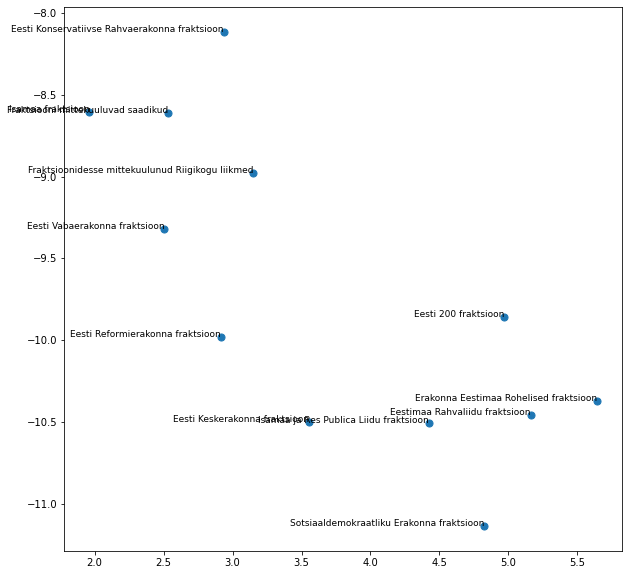

In [38]:
# Plot UMAP-reduced data with clusters
fig, ax=plt.subplots(figsize=(10,10))
plt.scatter(reduced_avg_latent_embeddings[:, 0], reduced_avg_latent_embeddings[:, 1], s=50)
# Adding labels to each point
for i, label in enumerate(factions2keep):
    plt.text(reduced_avg_latent_embeddings[i, 0], reduced_avg_latent_embeddings[i, 1], label, fontsize=9, ha='right')

plt.show()
plt.show()

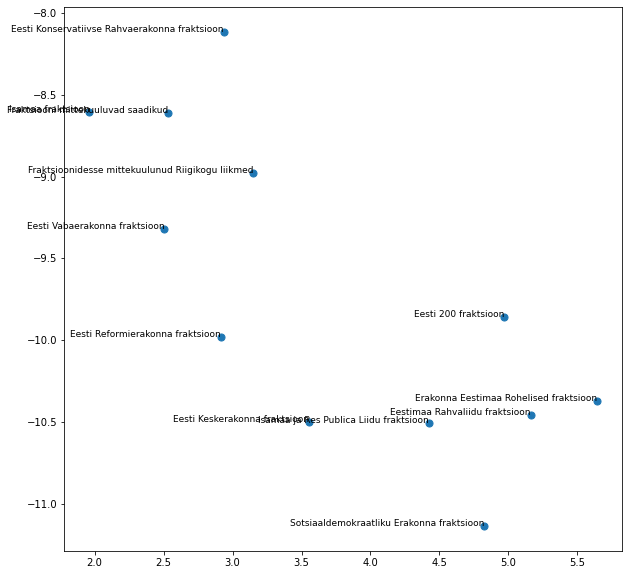

In [39]:
# Plot UMAP-reduced data with clusters
fig, ax=plt.subplots(figsize=(10,10))
plt.scatter(reduced_avg_latent_embeddings[:, 0], reduced_avg_latent_embeddings[:, 1], s=50)
# Adding labels to each point
for i, label in enumerate(factions2keep):
    plt.text(reduced_avg_latent_embeddings[i, 0], reduced_avg_latent_embeddings[i, 1], label, fontsize=9, ha='right')

plt.show()
plt.show()

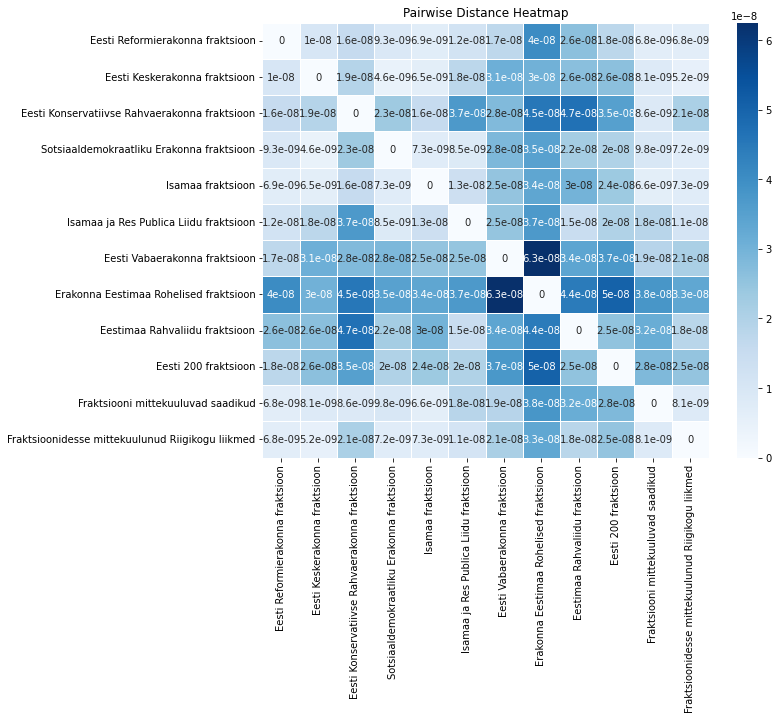

In [40]:
plot_pairwise_distances(faction_avg_latent_emb_ar, factions2keep)

<AxesSubplot:>

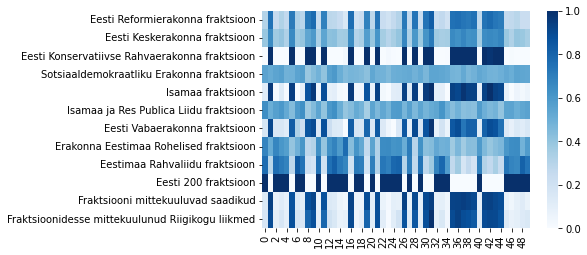

In [41]:
df_faction_avg_latent_emb_ar=pd.DataFrame(faction_avg_latent_emb_ar, index=factions2keep)
df_faction_avg_latent_emb_ar=(df_faction_avg_latent_emb_ar - df_faction_avg_latent_emb_ar.min()) / (df_faction_avg_latent_emb_ar.max() - df_faction_avg_latent_emb_ar.min())
sns.heatmap(df_faction_avg_latent_emb_ar, robust=True, cmap='Blues')

In [42]:
find_word_score_corr(faction_texts, factions2keep, reduced_avg_latent_embeddings[:, 0]).head(30)

,word,correlation
113,ja,0.665654
234,meile,0.647750
55,eelnõu,0.585369
195,lugemised,0.480384
467,toel,0.480384
565,üle,0.480384
460,teisel,0.480384
229,meel,0.480384
525,vastuvõtmiseks,0.480384
140,kindlasti,0.480384


In [43]:
find_word_score_corr(faction_texts, factions2keep, reduced_avg_latent_embeddings[:, 1]).head(30)

,word,correlation
128,kas,0.785207
203,ma,0.666530
282,oleks,0.650444
544,võimalik,0.591312
186,lihtsalt,0.582975
270,neid,0.582975
224,maksustamise,0.582975
266,nagu,0.582975
214,makse,0.529620
101,hoopis,0.518200


### Train autodencoder n times and calculate embs each time

In [44]:
N=50
embs_results=dict()

# Example: Simulate embeddings for 3 different speakers, each with a different number of texts
latent_dim = 50  # Dimension of the compressed embedding (latent space)

speaker_embeddings=[]
for faction  in factions2keep:
    # print(faction)
    texts_=df_orig_faction[df_orig_faction.fation==faction].text_splitted
    faction_texts[faction]=texts_.copy()
    # print(f'no of texts {texts_.shape[0]}')
    texts_ids_ = texts[texts['text_splitted'].isin(texts_)].index
    speaker_embeddings.append(torch.tensor(vec[texts_ids_]))
        
        
for n in range(N):
    print(f'iteration {n}')
    speaker_latent_embeddings=train_var(speaker_embeddings.copy(), latent_dim=latent_dim)
    # Print the resulting speaker embeddings (latent space) for each speaker
    speaker_avg_embeddings=[]
    for i, speaker_embedding in enumerate(speaker_latent_embeddings):
        speaker_avg_embeddings.append(torch.mean(speaker_embedding, dim=0).cpu().numpy())
        #print(f"Speaker {i + 1} Latent Embeddings: {speaker_embedding.shape}")
        
    faction_avg_latent_emb_ar=np.vstack(speaker_avg_embeddings)
    embs_results[n]=faction_avg_latent_emb_ar

iteration 0
Epoch [100/1000], Loss: 0.0013
Epoch [200/1000], Loss: 0.0013
Epoch [300/1000], Loss: 0.0013
Epoch [400/1000], Loss: 0.0012
Epoch [500/1000], Loss: 0.0010
Epoch [600/1000], Loss: 0.0009
Epoch [700/1000], Loss: 0.0008
Epoch [800/1000], Loss: 0.0008
Epoch [900/1000], Loss: 0.0008
Epoch [1000/1000], Loss: 0.0008
iteration 1
Epoch [100/1000], Loss: 0.0013
Epoch [200/1000], Loss: 0.0012
Epoch [300/1000], Loss: 0.0008
Epoch [400/1000], Loss: 0.0008
Epoch [500/1000], Loss: 0.0008
Epoch [600/1000], Loss: 0.0008
Epoch [700/1000], Loss: 0.0008
Epoch [800/1000], Loss: 0.0008
Epoch [900/1000], Loss: 0.0008
Epoch [1000/1000], Loss: 0.0008
iteration 2
Epoch [100/1000], Loss: 0.0013
Epoch [200/1000], Loss: 0.0012
Epoch [300/1000], Loss: 0.0009
Epoch [400/1000], Loss: 0.0008
Epoch [500/1000], Loss: 0.0008
Epoch [600/1000], Loss: 0.0008
Epoch [700/1000], Loss: 0.0008
Epoch [800/1000], Loss: 0.0008
Epoch [900/1000], Loss: 0.0008
Epoch [1000/1000], Loss: 0.0008
iteration 3
Epoch [100/1000], L

In [45]:
df_melted_all=pd.DataFrame()
for k, v in embs_results.items():
    dists_=calc_pairwise_dist(v, factions2keep)
    df_lower = dists_.where(np.tril(np.ones(dists_.shape)).astype(bool))
    df_reset = df_lower.reset_index()
    df_melted = pd.melt(df_reset, id_vars='index', var_name='Column', value_name='distance')
    df_melted = df_melted.dropna()
    df_melted=df_melted[df_melted.distance!=0]
    df_melted_all=df_melted_all.append(df_melted)

/tmp/ipykernel_1773498/12285822.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_melted_all=df_melted_all.append(df_melted)
/tmp/ipykernel_1773498/12285822.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_melted_all=df_melted_all.append(df_melted)
/tmp/ipykernel_1773498/12285822.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_melted_all=df_melted_all.append(df_melted)
/tmp/ipykernel_1773498/12285822.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_melted_all=df_melted_all.append(df_melted)
/tmp/ipykernel_1773498/12285822.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

In [46]:
df_melted_all.shape

(3300, 3)

In [47]:
df_melted_all['pair']=df_melted_all['index']+'-'+df_melted_all.Column

In [48]:
# Step 1: Group by 'pair'
grouped = df_melted_all.groupby('pair')

# Step 2: Plot histograms for each pair
#for name, group in grouped:
#    plt.figure(figsize=(8, 5))
#    plt.hist(group['distance'], bins=30, alpha=0.7, color='blue')
#    plt.title(f"Histogram of Distances for {name}")
#    plt.xlabel('Distance')
#    plt.ylabel('Frequency')
#    plt.grid(True)
#    plt.show()

In [49]:
df_melted_all.groupby('pair').distance.median().sort_values(ascending=False)

pair
Eesti 200 fraktsioon-Erakonna Eestimaa Rohelised fraktsioon                             6.728743e-08
Eesti 200 fraktsioon-Eestimaa Rahvaliidu fraktsioon                                     6.637415e-08
Eestimaa Rahvaliidu fraktsioon-Eesti Konservatiivse Rahvaerakonna fraktsioon            6.632142e-08
Erakonna Eestimaa Rohelised fraktsioon-Eesti Vabaerakonna fraktsioon                    6.271412e-08
Erakonna Eestimaa Rohelised fraktsioon-Eesti Konservatiivse Rahvaerakonna fraktsioon    6.117635e-08
                                                                                            ...     
Sotsiaaldemokraatliku Erakonna fraktsioon-Eesti Keskerakonna fraktsioon                 7.823977e-09
Fraktsiooni mittekuuluvad saadikud-Isamaa fraktsioon                                    7.684885e-09
Isamaa ja Res Publica Liidu fraktsioon-Sotsiaaldemokraatliku Erakonna fraktsioon        7.083361e-09
Isamaa fraktsioon-Eesti Reformierakonna fraktsioon                                    

In [50]:
df_melted_all.groupby('pair').distance.std().sort_values()

pair
Fraktsiooni mittekuuluvad saadikud-Isamaa fraktsioon                                   3.038997e-09
Fraktsioonidesse mittekuulunud Riigikogu liikmed-Isamaa fraktsioon                     6.946554e-09
Fraktsioonidesse mittekuulunud Riigikogu liikmed-Fraktsiooni mittekuuluvad saadikud    8.961512e-09
Isamaa ja Res Publica Liidu fraktsioon-Sotsiaaldemokraatliku Erakonna fraktsioon       1.204914e-08
Isamaa fraktsioon-Eesti Reformierakonna fraktsioon                                     1.802298e-08
                                                                                           ...     
Eesti 200 fraktsioon-Isamaa fraktsioon                                                 1.399087e-06
Fraktsiooni mittekuuluvad saadikud-Eesti 200 fraktsioon                                1.446942e-06
Fraktsioonidesse mittekuulunud Riigikogu liikmed-Eesti 200 fraktsioon                  1.514742e-06
Eesti 200 fraktsioon-Eesti Konservatiivse Rahvaerakonna fraktsioon                     1.894665

#### plot based on distances

In [51]:
#construct distance matrix
df_melted_all['p1']=df_melted_all.pair.apply(lambda x: x.split('-')[0])
df_melted_all['p2']=df_melted_all.pair.apply(lambda x: x.split('-')[1])

# Step 1: Extract the unique points (all unique values from p1 and p2 columns)
points = sorted(set(df_melted_all['p1']).union(set(df_melted_all['p2'])))

# Step 2: Create an empty distance matrix filled with NaN
n = len(points)
distance_matrix = np.full((n, n), np.nan)

# Step 3: Create a mapping from point label to index
point_to_idx = {point: i for i, point in enumerate(points)}

# Step 4: Fill the lower triangle of the distance matrix
for _, row in df_melted_all.iterrows():
    i = point_to_idx[row['p1']]
    j = point_to_idx[row['p2']]
    distance_matrix[i, j] = row['distance']
    distance_matrix[j, i] = row['distance']  # Symmetric property for distances

# Step 5: Fill the diagonal with zeros (distance to itself is 0)
np.fill_diagonal(distance_matrix, 0)

# Convert to DataFrame for easier visualization
distance_df = pd.DataFrame(distance_matrix, index=points, columns=points)
distance_df

,Eesti 200 fraktsioon,Eesti Keskerakonna fraktsioon,Eesti Konservatiivse Rahvaerakonna fraktsioon,Eesti Reformierakonna fraktsioon,Eesti Vabaerakonna fraktsioon,Eestimaa Rahvaliidu fraktsioon,Erakonna Eestimaa Rohelised fraktsioon,Fraktsiooni mittekuuluvad saadikud,Fraktsioonidesse mittekuulunud Riigikogu liikmed,Isamaa fraktsioon,Isamaa ja Res Publica Liidu fraktsioon,Sotsiaaldemokraatliku Erakonna fraktsioon
Eesti 200 fraktsioon,0.000000e+00,4.178105e-08,3.744919e-08,3.551471e-08,5.631186e-08,4.152382e-08,6.268532e-08,3.371023e-08,3.561227e-08,3.318446e-08,3.352356e-08,3.267061e-08
Eesti Keskerakonna fraktsioon,4.178105e-08,0.000000e+00,1.762292e-08,9.047591e-09,2.939582e-08,2.444600e-08,3.405584e-08,1.222767e-08,7.905077e-09,8.422505e-09,1.217240e-08,7.846686e-09
Eesti Konservatiivse Rahvaerakonna fraktsioon,3.744919e-08,1.762292e-08,0.000000e+00,1.429512e-08,3.030693e-08,4.176028e-08,3.460096e-08,1.183764e-08,1.504297e-08,1.425596e-08,2.608956e-08,1.824640e-08
Eesti Reformierakonna fraktsioon,3.551471e-08,9.047591e-09,1.429512e-08,0.000000e+00,1.684327e-08,2.847674e-08,2.648311e-08,5.726131e-09,4.376215e-09,6.106892e-09,9.531789e-09,6.071202e-09
Eesti Vabaerakonna fraktsioon,5.631186e-08,2.939582e-08,3.030693e-08,1.684327e-08,0.000000e+00,3.793186e-08,4.013800e-08,1.909910e-08,1.687055e-08,2.490470e-08,3.039642e-08,2.997832e-08
Eestimaa Rahvaliidu fraktsioon,4.152382e-08,2.444600e-08,4.176028e-08,2.847674e-08,3.793186e-08,0.000000e+00,3.661783e-08,3.490248e-08,2.380591e-08,3.138896e-08,1.390997e-08,1.836229e-08
Erakonna Eestimaa Rohelised fraktsioon,6.268532e-08,3.405584e-08,3.460096e-08,2.648311e-08,4.013800e-08,3.661783e-08,0.000000e+00,3.249978e-08,2.480878e-08,3.077160e-08,2.798637e-08,2.561610e-08
Fraktsiooni mittekuuluvad saadikud,3.371023e-08,1.222767e-08,1.183764e-08,5.726131e-09,1.909910e-08,3.490248e-08,3.249978e-08,0.000000e+00,7.047488e-09,1.339771e-08,1.823279e-08,1.171286e-08
Fraktsioonidesse mittekuulunud Riigikogu liikmed,3.561227e-08,7.905077e-09,1.504297e-08,4.376215e-09,1.687055e-08,2.380591e-08,2.480878e-08,7.047488e-09,0.000000e+00,5.764687e-09,9.575838e-09,7.359858e-09
Isamaa fraktsioon,3.318446e-08,8.422505e-09,1.425596e-08,6.106892e-09,2.490470e-08,3.138896e-08,3.077160e-08,1.339771e-08,5.764687e-09,0.000000e+00,1.145178e-08,8.573084e-09


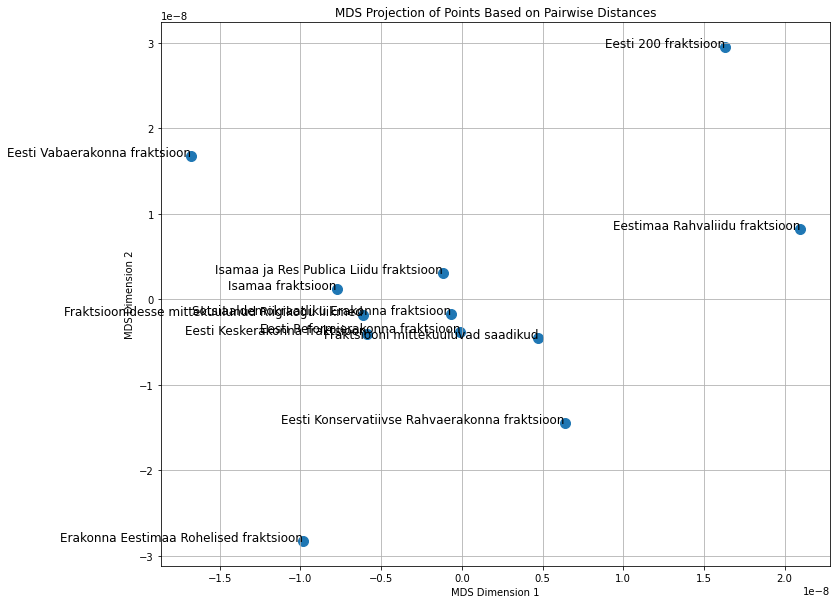

In [52]:
from sklearn.manifold import MDS

# Step 1: Perform MDS to reduce to 2D space
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
points_2d = mds.fit_transform(distance_df)

# Step 2: Plot the points
plt.figure(figsize=(12, 10))
plt.scatter(points_2d[:, 0], points_2d[:, 1], s=100)

# Annotate points with their labels
for i, label in enumerate(distance_df.columns):
    plt.text(points_2d[i, 0], points_2d[i, 1], label, fontsize=12, ha='right')

plt.title('MDS Projection of Points Based on Pairwise Distances')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.grid(True)
plt.show()

### 3-D

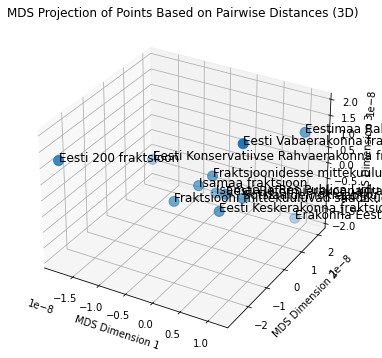

In [53]:
from mpl_toolkits.mplot3d import Axes3D

# Step 1: Perform MDS to reduce to 3D space
mds = MDS(n_components=3, dissimilarity='precomputed', random_state=42)
points_3d = mds.fit_transform(distance_df)

# Step 2: 3D Plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], s=100)

# Annotate points with their labels
for i, label in enumerate(distance_df.columns):
    ax.text(points_3d[i, 0], points_3d[i, 1], points_3d[i, 2], label, fontsize=12)

ax.set_title('MDS Projection of Points Based on Pairwise Distances (3D)')
ax.set_xlabel('MDS Dimension 1')
ax.set_ylabel('MDS Dimension 2')
ax.set_zlabel('MDS Dimension 3')
plt.show()

## PCA

In [54]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Example: Simulate embeddings for 3 different speakers with different numbers of texts
embedding_dim = vec.shape[-1]

# Step 1: Combine all embeddings into a single matrix
all_embeddings = np.vstack(speaker_embeddings)

# Step 2: Apply PCA to reduce dimensions from 300 to 50
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(all_embeddings)
tsne_embeddings=pca_embeddings
# Step 3: Apply t-SNE to further reduce dimensions to 2D or 3D for visualization
#tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
#tsne_embeddings = tsne.fit_transform(pca_embeddings)

# umap_reducer = umap.UMAP(n_components=2, random_state=42)
# tsne_embeddings = umap_reducer.fit_transform(all_embeddings)

# Step 4: Split the t-SNE embeddings back by speaker based on the original number of texts
num_texts_per_speaker = [embeddings.shape[0] for embeddings in speaker_embeddings]
start_idx = 0
tsne_speaker_embeddings = []

for num_texts in num_texts_per_speaker:
    end_idx = start_idx + num_texts
    tsne_speaker_embeddings.append(tsne_embeddings[start_idx:end_idx])
    start_idx = end_idx

# # Visualize the 2D t-SNE embeddings by speaker
# plt.figure(figsize=(8, 6))
# colors = ['r', 'g', 'b']

# for i, speaker_embedding in enumerate(tsne_speaker_embeddings):
#     plt.scatter(speaker_embedding[:, 0], speaker_embedding[:, 1], color=colors[i], label=f'Speaker {i+1}', alpha=0.6)

# plt.title('t-SNE of Text Embeddings by Speaker')
# plt.legend()
# plt.show()


In [55]:
speaker_tsne_avg_embeddings=[]
for i, speaker_embedding in enumerate(tsne_speaker_embeddings):
    speaker_tsne_avg_embeddings.append(np.mean(speaker_embedding, axis=0))
    #print(f"Speaker {i + 1} Latent Embeddings: {speaker_tsne_avg_embeddings.shape}")

In [56]:
speaker_tsne_avg_embeddings

[array([-0.00029883,  0.00831479], dtype=float32),
 array([-0.00471097, -0.0052446 ], dtype=float32),
 array([ 0.01649675, -0.00615013], dtype=float32),
 array([-0.00674354, -0.00050463], dtype=float32),
 array([-3.3000902e-05, -3.1550741e-03], dtype=float32),
 array([-0.00993799,  0.00526786], dtype=float32),
 array([-0.00036211,  0.01170577], dtype=float32),
 array([-0.00516978, -0.02037993], dtype=float32),
 array([-0.02183849, -0.00821588], dtype=float32),
 array([0.00482192, 0.00414358], dtype=float32),
 array([ 0.00073342, -0.00316312], dtype=float32),
 array([-0.00330481,  0.00289809], dtype=float32)]

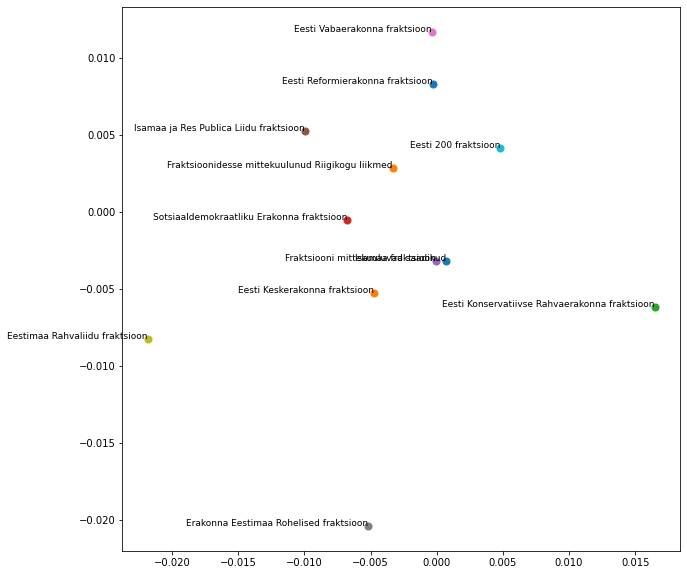

In [57]:
# Plot UMAP-reduced data with clusters
fig, ax=plt.subplots(figsize=(10,10))
#plt.scatter(speaker_tsne_avg_embeddings[:, 0], speaker_tsne_avg_embeddings[:, 1], s=50)
# Adding labels to each point
for i, label in enumerate(factions2keep):
    plt.scatter(speaker_tsne_avg_embeddings[i][ 0], speaker_tsne_avg_embeddings[i][ 1], s=50)
    plt.text(speaker_tsne_avg_embeddings[i][ 0], speaker_tsne_avg_embeddings[i][ 1], label, fontsize=9, ha='right')

plt.show()
plt.show()

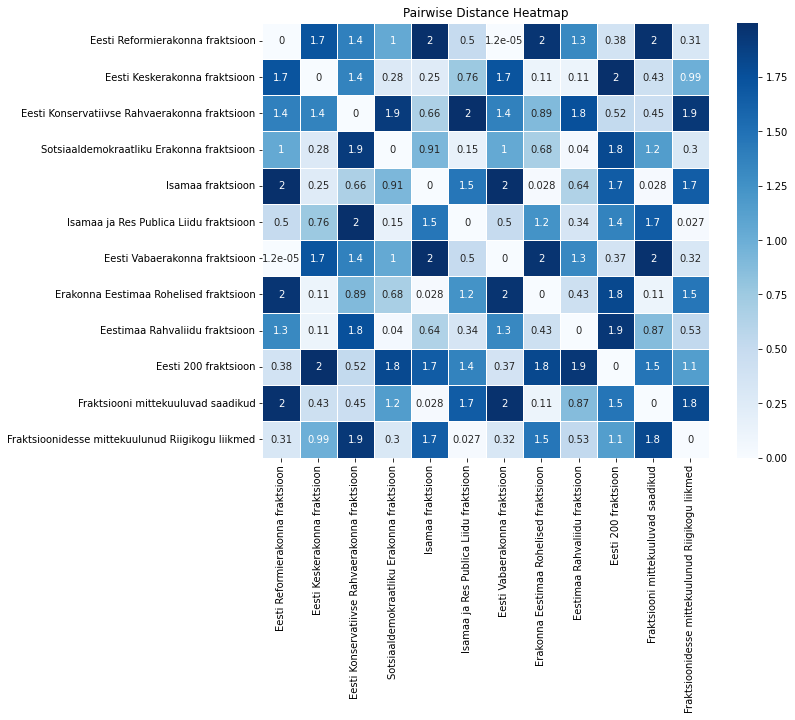

In [58]:
plot_pairwise_distances(speaker_tsne_avg_embeddings, factions2keep)

In [59]:
find_word_score_corr(faction_texts, factions2keep, [speaker_tsne_avg_embeddings[i][ 0] for i in range(len(speaker_tsne_avg_embeddings))]).head(30)

,word,correlation
128,kas,0.705548
538,välja,0.647750
544,võimalik,0.591312
224,maksustamise,0.582975
186,lihtsalt,0.582975
270,neid,0.582975
266,nagu,0.582975
410,selline,0.543197
282,oleks,0.532181
214,makse,0.529620


In [60]:
find_word_score_corr(faction_texts, factions2keep, [speaker_tsne_avg_embeddings[i][1] for i in range(len(speaker_tsne_avg_embeddings))]).head(30)

,word,correlation
268,need,0.752618
416,sest,0.582975
159,kui,0.559776
448,te,0.514136
123,jätkan,0.480384
451,teenus,0.480384
452,teenuse,0.480384
453,teenusega,0.480384
455,tegemist,0.480384
459,teilt,0.480384
